## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

# 試比較 save_best_only 與否的差異

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
SAVE_BEST = [True, False]

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for savebest in SAVE_BEST:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with savebest = %s" % (str(savebest)))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model_ckpt = ModelCheckpoint(filepath="Day_086_HW_"+str(savebest)+".h5", 
                                 monitor="val_loss", 
                                 save_best_only=savebest)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "savebest-%s" % (str(savebest))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with savebest = True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)    

50000/50000 [==============================] - 3s 63us/step - loss: 0.5164 - acc: 0.8545 - val_loss: 1.6496 - val_acc: 0.4929
Epoch 50/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.4988 - acc: 0.8610 - val_loss: 1.6858 - val_acc: 0.4854
Experiment with savebest = False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)   

50000/50000 [==============================] - 3s 64us/step - loss: 0.5481 - acc: 0.8415 - val_loss: 1.6554 - val_acc: 0.4868
Epoch 48/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.5277 - acc: 0.8503 - val_loss: 1.6639 - val_acc: 0.4884
Epoch 49/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.5128 - acc: 0.8554 - val_loss: 1.6805 - val_acc: 0.4843
Epoch 50/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.4976 - acc: 0.8613 - val_loss: 1.7034 - val_acc: 0.4819


In [8]:
# Load back
model = keras.models.load_model("Day_086_HW_True.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 91us/step


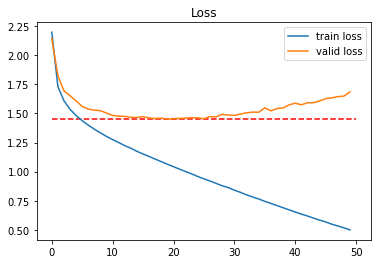

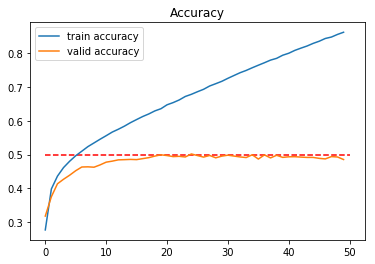

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
plt.plot(range(len(results['savebest-True']['train-loss'])), results['savebest-True']['train-loss'], label="train loss")
plt.plot(range(len(results['savebest-True']['valid-loss'])), results['savebest-True']['valid-loss'], label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(results['savebest-True']['train-loss']), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(results['savebest-True']['train-acc'])), results['savebest-True']['train-acc'], label="train accuracy")
plt.plot(range(len(results['savebest-True']['valid-acc'])), results['savebest-True']['valid-acc'], label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(results['savebest-True']['valid-acc']), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

In [10]:
# Load back
model = keras.models.load_model("Day_086_HW_False.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 91us/step


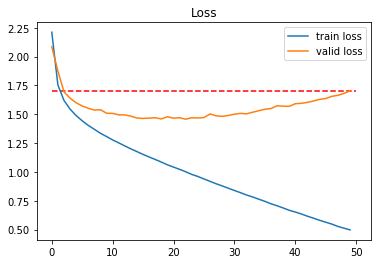

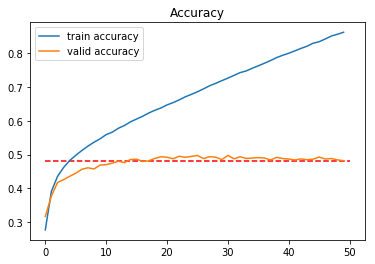

In [11]:
plt.plot(range(len(results['savebest-False']['train-loss'])), results['savebest-False']['train-loss'], label="train loss")
plt.plot(range(len(results['savebest-False']['valid-loss'])), results['savebest-False']['valid-loss'], label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(results['savebest-False']['train-loss']), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(results['savebest-False']['train-acc'])), results['savebest-False']['train-acc'], label="train accuracy")
plt.plot(range(len(results['savebest-False']['valid-acc'])), results['savebest-False']['valid-acc'], label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(results['savebest-False']['valid-acc']), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

# 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [16]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model_ckpt = ModelCheckpoint(filepath="Day_086_HW_Weights.weight", 
                             monitor="val_loss", 
                             save_best_only=True,
                             save_weights_only=True)
    
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )
    
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

Epoch 50/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.4850 - acc: 0.8657 - val_loss: 1.6817 - val_acc: 0.4850


In [18]:
model = build_mlp(input_shape=x_train.shape[1:])
model.load_weights("Day_086_HW_Weights.weight")
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 105us/step


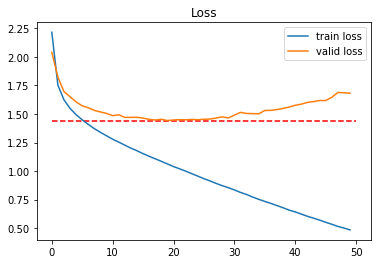

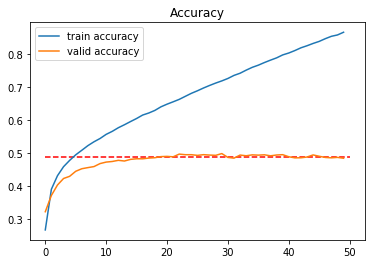

In [19]:
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()